When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obamaâs page.

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load Wikipedia dataset

We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [161]:
wiki = pd.read_csv('../../people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

In [162]:
# from IPython.display import HTML
# print(wiki['text'][0])
# HTML(url=wiki['URI'][0])

## Ex. 1: Extract word count vectors

As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [163]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", max_features=10000)
WCmatrix = vectorizer.fit_transform(wiki['text'])

## Ex. 2: Find nearest neighbors

**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

### So the Euclidean Distance tells us how two articles are similar to each other. The lower distance is, the bigger similarity of two documents.

In [164]:
from sklearn.metrics import pairwise_distances

obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
dist = pairwise_distances(WCmatrix[obama_index], WCmatrix, metric='euclidean')
wiki['BO-eucl'] = dist.flatten()
wiki.sort_values(by='BO-eucl', ascending=True)[['name', 'BO-eucl']].head(10)

,name,BO-eucl
35817,Barack Obama,0.000000
24478,Joe Biden,31.352831
28447,George W. Bush,33.660065
48202,Tony Vaccaro,33.749074
14754,Mitt Romney,34.365681
31423,Walter Mondale,34.438351
36364,Don Bonker,34.612137
13229,Francisco Barrio,34.684290
35357,Lawrence Summers,35.397740
22745,Wynn Normington Hugh-Jones,35.454196


Barack Obama is the same as Barack Obama article (because distance is 0)
Then Article about Joe Biden is the most similar.

**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [165]:
bush_index = wiki[wiki['name'] == 'George W. Bush'].index[0]
biden_index = wiki[wiki['name'] == 'Joe Biden'].index[0]

obama_bush_dist = pairwise_distances(WCmatrix[obama_index], WCmatrix[bush_index], metric='euclidean')
print(f"Distance between Obama and Bush: {obama_bush_dist[0][0]}")

obama_biden_dist = pairwise_distances(WCmatrix[obama_index], WCmatrix[biden_index], metric='euclidean')
print(f"Distance between Obama and Biden: {obama_biden_dist[0][0]}")

bush_biden_dist = pairwise_distances(WCmatrix[bush_index], WCmatrix[biden_index], metric='euclidean')
print(f"Distance between Bush and Biden: {bush_biden_dist[0][0]}")

Distance between Obama and Bush: 33.66006535941367
Distance between Obama and Biden: 31.352830813181765
Distance between Bush and Biden: 30.919249667480614


### The smallest distance (the biggest similarity) is with George Bush article.

All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [166]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    person_index = wiki[wiki['name'] == name].index[0]
    word_counts = WCmatrix[person_index].toarray()[0]
    words = vectorizer.get_feature_names_out()
    df = pd.DataFrame({'word': words, 'count': word_counts})
    
    return df.sort_values(by='count',ascending=False)

In [167]:
obama_words = top_words('Barack Obama')
obama_words.head(20)

,word,count
9062,the,40
4613,in,30
720,and,21
6377,of,18
9161,to,14
4385,his,11
6341,obama,9
453,act,8
372,a,7
4282,he,7


In [168]:
barrio_words = top_words('Francisco Barrio')
barrio_words.head(20)

,word,count
9062,the,36
6377,of,24
720,and,18
4613,in,17
4282,he,10
9161,to,9
372,a,6
4084,governor,6
900,as,5
4385,his,5


**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [169]:
common_words = obama_words.set_index('word').join(barrio_words.set_index('word'), lsuffix='_Obama', rsuffix='_Barrio', how='inner')
common_words.sort_values(by='count_Barrio', ascending=False).head(5)

,count_Obama,count_Barrio
word,,
the,40,36
of,18,24
and,21,18
in,30,17
he,7,10


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [170]:
bush_words = top_words('George W. Bush')
common_words = obama_words.set_index('word').join(bush_words.set_index('word'), lsuffix='_Obama', rsuffix='_Bush', how='inner')
common_words.sort_values(by='count_Obama', ascending=False).head(10)

,count_Obama,count_Bush
word,,
the,40,39
in,30,22
and,21,14
of,18,14
to,14,11
his,11,6
obama,9,0
act,8,3
a,7,6


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [171]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

common_obama_barrio = obama_words.set_index('word').join(barrio_words.set_index('word'), lsuffix='_Obama', rsuffix='_Barrio', how='inner')
top_15_words = common_obama_barrio.sort_values(by='count_Obama', ascending=False).head(15).index.tolist()

word_indices = [word_to_ind[word] for word in top_15_words]

sub_matrix = WCmatrix[:, word_indices]

import numpy as np
articles = np.asarray((sub_matrix > 0).sum(axis=1) == len(word_indices)).flatten()
print(articles.sum())

print("Articles that contain all 15 words:")
print(wiki[articles]['name'])

2
Articles that contain all 15 words:
24478       Joe Biden
35817    Barack Obama
Name: name, dtype: object


In [172]:
wiki[articles]['name']

24478       Joe Biden
35817    Barack Obama
Name: name, dtype: object

## Ex. 3: TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequencyâinverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [173]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
WCmatrix = vectorizer.fit_transform(wiki['text'])

tfidf = TfidfTransformer(smooth_idf=False, norm=None)
TFIDFmatrix = tfidf.fit_transform(WCmatrix)

obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
bush_index = wiki[wiki['name'] == 'George W. Bush'].index[0]
biden_index = wiki[wiki['name'] == 'Joe Biden'].index[0]
obama_bush_dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix[bush_index], metric='euclidean')
print(f"TF-IDF Distance between Obama and Bush: {obama_bush_dist[0][0]}")
obama_biden_dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix[biden_index], metric='euclidean')
print(f"TF-IDF Distance between Obama and Biden: {obama_biden_dist[0][0]}")
bush_biden_dist = pairwise_distances(TFIDFmatrix[bush_index], TFIDFmatrix[biden_index], metric='euclidean')
print(f"TF-IDF Distance between Bush and Biden: {bush_biden_dist[0][0]}")

TF-IDF Distance between Obama and Bush: 158.9922099413075
TF-IDF Distance between Obama and Biden: 148.77845413077898
TF-IDF Distance between Bush and Biden: 162.43356031278952


In [174]:
# now recompute the distances as before but for TF-IDF
dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix, metric='euclidean')
# add the distances as a column in the wiki dataframe
wiki['BO-eucl-TF-IDF'] = dist.flatten()

# Display the 10 nearest neighbors
wiki.sort_values(by='BO-eucl-TF-IDF', ascending=True)[['name', 'BO-eucl-TF-IDF']].head(10)

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [175]:
def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's wikipedia page.
    """
    person_index = wiki[wiki['name'] == name].index[0]
    tfidf_scores = TFIDFmatrix[person_index].toarray()[0]
    words = vectorizer.get_feature_names_out()
    df = pd.DataFrame({'word': words, 'tf-idf': tfidf_scores})
    
    return df.sort_values(by='tf-idf', ascending=False)

In [176]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
common_words = obama_tf_idf.set_index('word').join(schiliro_tf_idf.set_index('word'), lsuffix='_Obama', rsuffix='_Schiliro', how='inner')
common_words.sort_values(by='tf-idf_Obama', ascending=False)

,tf-idf_Obama,tf-idf_Schiliro
word,,
obama,52.295653,11.621256
the,40.004063,10.001016
act,35.678223,0.000000
in,30.028962,5.004827
iraq,21.747379,0.000000
...,...,...
zyskowicz,0.000000,0.000000
zysman,0.000000,0.000000
zysmans,0.000000,0.000000


**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [177]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

common_obama_schiliro = obama_tf_idf.set_index('word').join(schiliro_tf_idf.set_index('word'), lsuffix='_Obama', rsuffix='_Schiliro', how='inner')
top_15_words = common_obama_schiliro.sort_values(by='tf-idf_Obama', ascending=False).head(15).index.tolist()

word_indices = [word_to_ind[word] for word in top_15_words]

sub_matrix = WCmatrix[:, word_indices]

articles = np.asarray((sub_matrix > 0).sum(axis=1) == len(word_indices)).flatten()

articles.sum()

np.int64(1)

** So it's one article that cotains all these 15 words **

In [178]:
wiki[articles]['name']

35817    Barack Obama
Name: name, dtype: object

In [179]:
print(f"Top 15 words: {top_15_words}")

Top 15 words: ['obama', 'the', 'act', 'in', 'iraq', 'and', 'law', 'control', 'of', 'us', 'ordered', 'military', 'democratic', 'response', 'involvement']


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [180]:
dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix[biden_index], metric='euclidean')
print(f"Euclidean distance between Obama and Biden TF-IDF: {dist[0][0]}")

Euclidean distance between Obama and Biden TF-IDF: 148.77845413077898


The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [181]:
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:10]

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [182]:
tokenizer = vectorizer.build_tokenizer()

def compute_length(row):
    return len(tokenizer(row['text']))

wiki['length'] = wiki.apply(compute_length, axis=1)

In [183]:
nearest_neighbors_euclidean = wiki.sort_values(by='BO-eucl-TF-IDF', ascending=True)[['name', 'length', 'BO-eucl-TF-IDF']]
print(nearest_neighbors_euclidean.head(100))

                          name  length  BO-eucl-TF-IDF
35817             Barack Obama     540        0.000000
38376           Samantha Power     310      139.364493
46811            Jeff Sessions     230      139.757740
7914             Phil Schiliro     208      139.812175
38714  Eric Stern (politician)     255      140.450064
...                        ...     ...             ...
12834      Mark Waller (judge)     211      146.796202
11303          Steven Weinberg     227      146.815087
8277          John M. Facciola     207      146.823495
11996        Thomas H. Jackson     216      146.836489
50366  Patrick Lipton Robinson     201      146.849274

[100 rows x 3 columns]


**Table** shows the top 100 nearest neighbors to Barack Obama's Wikipedia article, sorted by increasing Euclidean distance in TF-IDF space (BO-eucl-TF-IDF column).

Barack Obama has a distance of 0 (identical to itself).
The next articles have progressively larger distances, indicating decreasing similarity based on word content (weighted by TF-IDF for rarity).

Document lengths (length column) are mostly short (under 300 words), highlighting a bias in Euclidean distance: it favors shorter articles because their TF-IDF vectors are shorter, leading to smaller distances.

For example, Samantha Power (310 words) appears closer than Joe Biden (who is thematically similar but has a longer article).

This bias occurs because Euclidean distance measures straight-line distance in high-dimensional space. Shorter documents have smaller vectors, making them seem "closer." 

**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

All lengths min: 201 max: 5351
Nearest lengths min: 201 max: 540


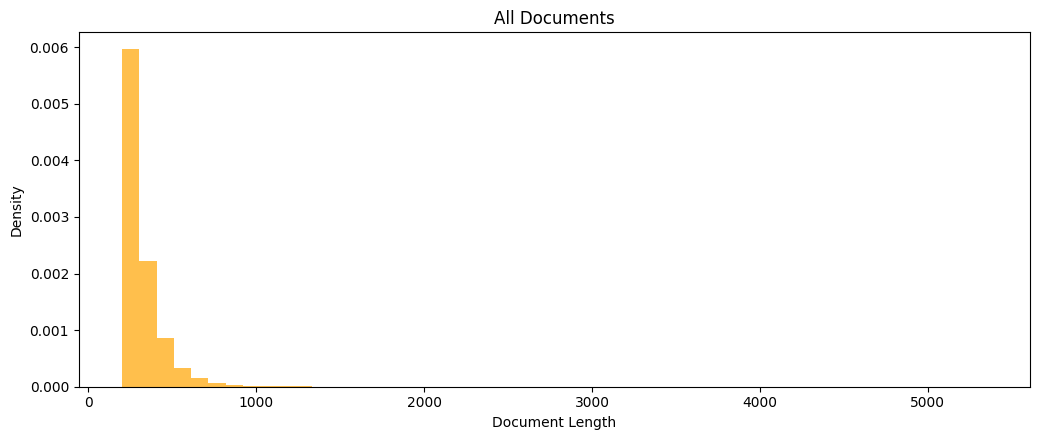

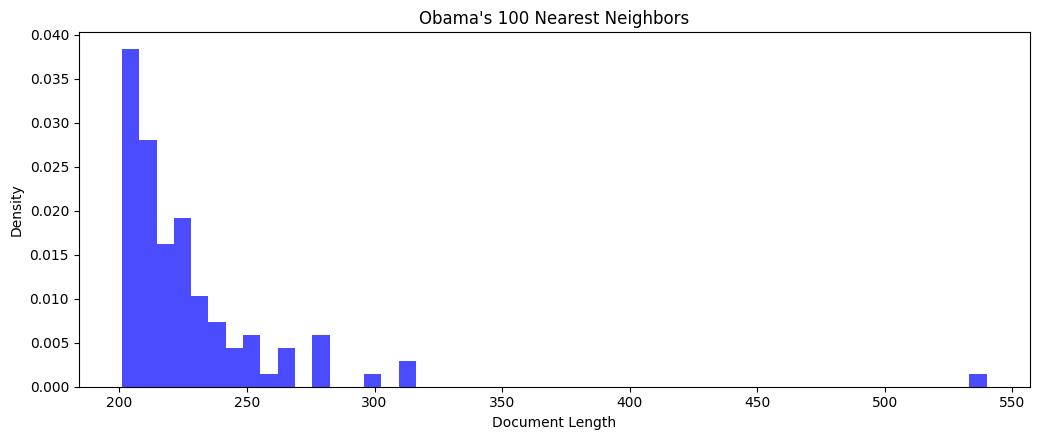

In [184]:
print("All lengths min:", wiki['length'].min(), "max:", wiki['length'].max())
print(
    "Nearest lengths min:",
    nearest_neighbors_euclidean.head(100)['length'].min(),
    "max:",
    nearest_neighbors_euclidean.head(100)['length'].max()
)

plt.figure(figsize=(10.5, 4.5))
plt.hist(
    wiki['length'],
    bins=50,
    alpha=0.7,
    color='orange',
    density=True
)
plt.title('All Documents')
plt.xlabel('Document Length')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10.5, 4.5))
plt.hist(
    nearest_neighbors_euclidean.head(100)['length'],
    bins=50,
    alpha=0.7,
    color='blue',
    density=True
)
plt.title("Obama's 100 Nearest Neighbors")
plt.xlabel('Document Length')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


The first histogram shows the distribution of document lengths for all Wikipedia articles.
In this distribution:
most documents are relatively short,
a small number of articles are very long, creating a long tail to the right.

The second histogram presents the distribution of document lengths for Barack Obama’s 100 nearest neighbors (based on TF-IDF similarity). It is more concentrated around a specific range of lengths (approximately 200–300 words),

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [185]:
dist = pairwise_distances(TFIDFmatrix[obama_index], TFIDFmatrix, metric='cosine')
wiki['BO-cos-TF-IDF'] = dist.flatten()
nearest_neighbors_cosine = wiki.sort_values(by='BO-cos-TF-IDF', ascending=True)[['name', 'length', 'BO-cos-TF-IDF']].head(100)

print(nearest_neighbors_cosine)

                                  name  length  BO-cos-TF-IDF
35817                     Barack Obama     540   1.110223e-15
24478                        Joe Biden     414   5.727248e-01
57108           Hillary Rodham Clinton     580   6.161487e-01
38376                   Samantha Power     310   6.257966e-01
38714          Eric Stern (politician)     255   6.514751e-01
...                                ...     ...            ...
2045             Allan Ryan (attorney)     291   7.313755e-01
47085                     Ray Thornton     326   7.319076e-01
16392  P%C3%A9ter Kov%C3%A1cs (lawyer)     365   7.321718e-01
55495               Lokman Singh Karki    2486   7.326076e-01
22304                 Chung Dong-young     886   7.327848e-01

[100 rows x 3 columns]


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

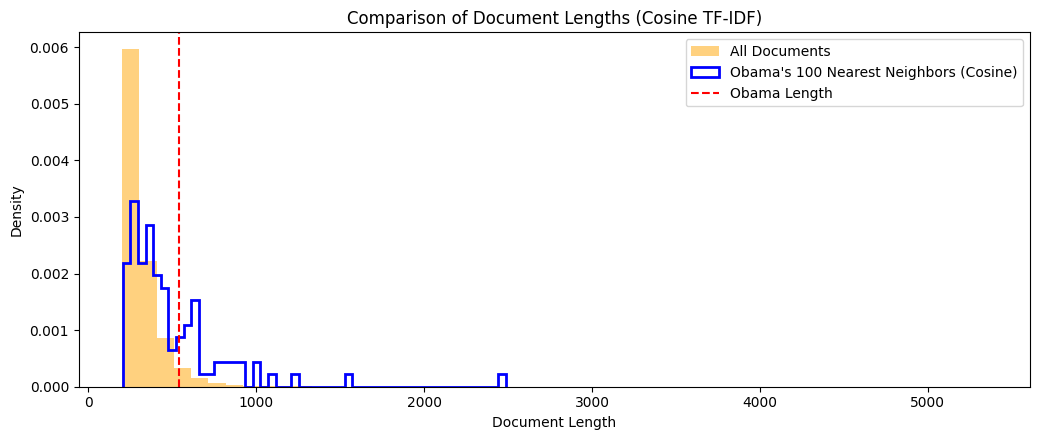

In [186]:
plt.figure(figsize=(10.5, 4.5))

plt.hist(
    wiki['length'],
    bins=50,
    alpha=0.5,
    color='orange',
    label='All Documents',
    density=True
)

plt.hist(
    nearest_neighbors_cosine['length'],
    bins=50,
    histtype='step',
    linewidth=2,
    color='blue',
    label="Obama's 100 Nearest Neighbors (Cosine)",
    density=True
)

plt.axvline(
    x=wiki.loc[obama_index, 'length'],
    color='red',
    linestyle='--',
    label='Obama Length'
)

plt.xlabel('Document Length')
plt.ylabel('Density')
plt.title('Comparison of Document Lengths (Cosine TF-IDF)')
plt.legend()
plt.tight_layout()
plt.show()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Barack Obama's Wikipedia article? 

In [187]:
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})

tweet_WCmatrix = vectorizer.transform(df['text'])
tweet_TFIDFmatrix = tfidf.transform(tweet_WCmatrix)
print(f"TF-IDF features for the tweet:{tweet_TFIDFmatrix}")

TF-IDF features for the tweet:<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9 stored elements and shape (1, 548465)>
  Coords	Values
  (0, 45084)	4.459777827872489
  (0, 138596)	4.7217652112953274
  (0, 155950)	4.102672174333041
  (0, 221573)	5.167571323949673
  (0, 251924)	1.0009654063501214
  (0, 292533)	3.4538226269605703
  (0, 391376)	3.764478952022998
  (0, 417836)	5.261461747058352
  (0, 494571)	1.0469449376817992


Let's compare this tweet's TF-IDF vectors  to Barack Obama's Wikipedia entry.

In [188]:
from sklearn.metrics.pairwise import cosine_distances # for one pair of samples we can just use this function


obama_tf_idf = top_words_tf_idf('Barack Obama')

obama_tfidf_vector = TFIDFmatrix[obama_index]
tweet_tfidf_vector = tweet_TFIDFmatrix

distance = cosine_distances(obama_tfidf_vector, tweet_tfidf_vector)
print(f"Cosine distance between Obama's article and the tweet: {distance[0][0]}")

Cosine distance between Obama's article and the tweet: 0.6986645349790674


The cosine distance of `0.6986645349790674` suggests low similarity between the tweet and Obama's Wikipedia article. A value closer to 0 indicates higher similarity (vectors are more aligned).

**b)** Now, compute the cosine distance between the Barack Obama article and this tweet:

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia nearest neighbors:

In [189]:
nearest_neighbors_cosine[0:23]

,name,length,BO-cos-TF-IDF
35817,Barack Obama,540,1.110223e-15
24478,Joe Biden,414,5.727248e-01
57108,Hillary Rodham Clinton,580,6.161487e-01
38376,Samantha Power,310,6.257966e-01
38714,Eric Stern (politician),255,6.514751e-01
28447,George W. Bush,505,6.594783e-01
39357,John McCain,410,6.616452e-01
48693,Artur Davis,371,6.666905e-01
18827,Henry Waxman,279,6.712258e-01
37199,Barry Sullivan (lawyer),893,6.732998e-01


With cosine distances, the tweet is "nearer" to Barack Obama than most people! If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet?
In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.